In [110]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.
     
       Prints the result to stdout and returns the exit status. 
       Provides a printed warning on non-zero exit status unless `warn` 
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs236299-2020/lab2-2.git .tmp
 mv .tmp/tests ./
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

In [111]:
# Initialize Otter
import otter
grader = otter.Notebook()

%%latex
\newcommand{\vect}[1]{\mathbf{#1}}
\newcommand{\cnt}[1]{\sharp(#1)}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\softmax}{\operatorname{softmax}}
\newcommand{\Prob}{\Pr}
\newcommand{\given}{\,|\,}

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

# Course 236299
## Lab 2-2 – Recurrent neural networks

You've read about recurrent neural networks, but there's nothing like carrying out the calculations yourself to really understand what's going on in these systems. In this lab, you'll carry out RNN calculations by hand or by programming – both forward (calculating outputs from inputs) and backward (computing gradients) – and use RNNs to simulate bigram language models.

New bits of Python used for the first time in the _solution set_ for this lab, and which you may therefore find useful:

* [`torch.clamp`](https://pytorch.org/docs/stable/generated/torch.clamp.html#torch.clamp): restricts all elements of a tensor to a specific range
* [`torch.diag`](https://pytorch.org/docs/stable/generated/torch.diag.html#torch-diag): creates a tensor with the given inputs as the diagonal
* [`torch.eye`](https://pytorch.org/docs/stable/generated/torch.eye.html#torch-eye): creates an identity matrix
* [`torch.mv`](https://pytorch.org/docs/stable/generated/torch.mv.html#torch-mv) (typically invoked via the `@` operator): matrix-vector multiplication
* [`torch.prod`](https://pytorch.org/docs/stable/generated/torch.prod.html#torch-prod): takes the product of elements in a vector
* [`torch.T`](https://pytorch.org/docs/stable/generated/torch.t.html#torch.t): returns the transpose of a tensor
* [`torch.zeros`](https://pytorch.org/docs/stable/generated/torch.zeros.html#torch-zeros): creates a matrix of zeros

## Preparation – Loading packages

In [112]:
import torch

# Script for visualizing computation graphs
shell(f'wget -nv -N "https://raw.githubusercontent.com/nlp-236299/data/master/scripts/makedot.py"')
from makedot import make_dot

In [113]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## The forward step

A recurrent neural network (RNN) works by calculating a sequence of hidden states $\vect{h} = \langle h_0, \ldots, h_N \rangle$ and outputs $\vect{o} = \langle o_1, \ldots, o_N \rangle$ from a sequence of inputs $\vect{x} =  \langle x_1, \ldots, x_N \rangle$. (We're notating the elements, like $x_t$, $h_t$, and $o_t$ as if they are scalars, but you should keep in mind that they might well be vectors themselves.)

Each hidden state $h_t$ and output $o_t$ of an RNN is calculated from an input $x_{t}$ and the previous hidden state $h_{t - 1}$ using a set of weights $\vect{U}$, $\vect{V}$, and $\vect{W}$ according to the following equations. (We ignore all biases for simplicity, and due to the fact that in large neural networks they make no big difference.)

\begin{align}
h_t &= \sigma(\vect{U}x_t + \vect{V}h_{t - 1}) \\
o_t &= \vect{W}h_t 
\end{align}

<!-- BEGIN QUESTION -->

---

<!--
BEGIN QUESTION
name: open_response_numbering
manual: true
-->

**Question:** To check your understanding, notice that we've defined $\vect{h}$ so that it has one more element than $\vect{x}$ and $\vect{o}$. Why is this?

The number of outputs corresponds to the number of inputs, that's why there is same number of x and o (for each input an output). For each input there is the "memory" of the reccurent neural network, i.e the hidden state, so for each input there is the hidden state which remembers it, i.e there are at least N hidden states. There is an additional one for the initial input, as: h_1 = activation_func(U@x_1+V@h_0), so we need also h_0, as an initial state which is probably 0 without any prior knowledge or rnn preloading and e.t.c (but it can be anything according to user's will).

<!-- END QUESTION -->



---

### Defining the RNN and its input

To better understand this process, we set up some RNN parameters and values for $x_1$ and $x_2$ in the next cell, so that you can carry out the RNN operations yourself to calculate $h_1$, $h_2$, $o_1$, and $o_2$.


In [114]:
# RNN parameters
U = torch.Tensor([ [-0.3,  0.6],
                   [ 0.2,  0.1] ])
V = torch.Tensor([ [ 0.4,  0.4],
                   [ 0.9, -0.7] ])
W = torch.Tensor([ [ 0.2,  0.1],
                   [-0.2,  0.5] ])

# inputs
x1 = torch.Tensor([0.0, 1.0])
x2 = torch.Tensor([0.3, 0.4])

# initial value for the hidden state, a zero vector
h0 = torch.Tensor([0, 0])

# Set which nodes to visualize later
visualized_nodes = [U, V, W, x1, x2, h0]
for p in visualized_nodes:
    p.requires_grad = True

### Carrying out the forward step

Given these definitions, calculate values for $h_1$, $h_2$, $o_1$, and $o_2$ using `torch` operations.

You may assume for this problem that the nonlinearity $\sigma$ used in calculating $h_t$ is a Rectified Linear Unit (ReLU), defined by 

$$\operatorname{ReLU}(x) = \max(0, x)$$ 

> ReLU can be implemented as `torch.clamp(x, min=0)`

<!--
BEGIN QUESTION
name: forward
-->

In [115]:
# TODO: calculate h1, h2, o1, and o2 using torch operations
h1 = torch.clamp(U@x1+V@h0, 0)
o1 = W@h1
h2 = torch.clamp(U@x2+V@h1, 0)
o2 = W@h2

In [116]:
grader.check("forward")

All tests passed!

We print out the results for manual verification

In [117]:
print (f"o1:\t{o1} \n"
       f"o2:\t{o2}")

o1:	tensor([ 0.1300, -0.0700], grad_fn=<MvBackward>) 
o2:	tensor([0.1430, 0.1990], grad_fn=<MvBackward>)


### Visualizing the computation graph

Now, we can visualize the computation graph, that is, the graph of how $o_1$ and $o_2$ are computed from other variables and parameters. 

> Note that to make the below code work, you need to install `graphviz`:
>
> * MacOS: `brew install graphviz`
> * Deepnote: already installed
> * Google Colab: already installed
> * Ubuntu: `sudo apt-get install graphviz`
>
> On Deepnote, the below code might not show anything, but you can check the generated PDF in `computation_graph.pdf`.

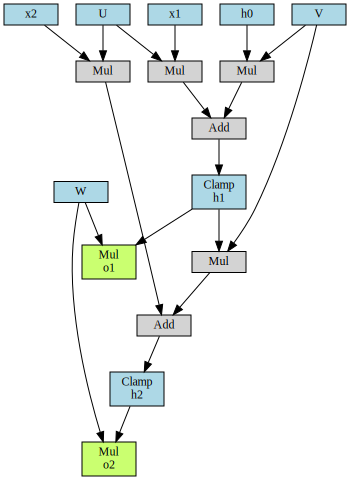

In [118]:
# Define the mapping from variable name to variable,
# such that the nodes in our computation graph can be labeled
params = {k: eval(k) for k in ['U', 'V', 'W', 
                               'x1', 'x2', 
                               'h0', 
                               'h1', 'o1', 
                               'h2', 'o2']}

# Visualize the computation graph constructed by PyTorch
dot = make_dot((o1, o2), params=params)

# Save Graph to `computation_graph.pdf`
dot.render('computation_graph')

# Visualize (not working in Deepnote)
dot

Is the generated computation graph what you expected?

## Expressing bigram language models via RNNs

In this section, as an exercise in understanding how RNNs work, you'll design an RNN to behave like a bigram model, thereby showing that RNNs are (not surprisingly) more expressive than bigram language models.

### Bigram language models

Recall that a bigram language model uses the previous word to predict the next word in a sequence $w_1 \cdots w_N$. A bigram model over a vocabulary $\vect{v} = \{v_1, \ldots, v_V\}$ is specified by a set of probabilities $\Prob(w_{t+1} = v_j \given w_t = v_i)$, the probability that a word of type $v_j$ follows a word of type $v_i$. 
(As usual, we'll abbreviate this probability $\Prob(v_j \given v_i)$, since the probability is assumed to be the same for all $t$.)

We can pack these probabilities into a single table $T$ with $V$ rows and $V$ columns such that  

$$T_{ij} = \Prob(w_{t+1} = v_j \given w_t = v_i)$$

Importantly, the sum $\sum_{j=1}^{V} T_{ij}$ is $1$ for all $i$. The vector $T_i$ (the $i$-th row of table $T$) thus constitutes the probability distribution for the word following $v_i$.

For this activity, we use a vocabulary with only two tokens (we can think of them as $a$ and $b$) encoded as one-hot vectors ($v_1=$ `[1,0]` and $v_2=$  `[0,1]`) and we provide a transition table $T$. We also define two sample sequences representing $aaaaaabbaa$ and $babbbbabbb$.

In [119]:
# the vocabulary
Vocab = torch.Tensor([ [1, 0], 
                       [0, 1] ])

# the transition matrix
T = torch.Tensor([ [0.6, 0.4],
                   [0.3, 0.7] ])

# two sample sequences
seq1 = torch.Tensor(
    [ [1,0], [1,0], [1,0], [1,0], [1,0], 
      [1,0], [0,1], [0,1], [1,0], [1,0] ])
seq2 = torch.Tensor(
    [ [0,1], [1,0], [0,1], [0,1], [0,1],
      [0,1], [1,0], [0,1], [0,1], [0,1] ])

Before proceeding, take a guess as to which of the two sequences would be more likely according ot the provided bigram model. (We won't hold you to the guess.)

Now write a function `sequence_probability` to find the probability of a sequence according to the bigram model. Below, we'll use that function to check your guess.

<!--
BEGIN QUESTION
name: bigram
-->

In [120]:
import math
# TODO -- Write a function to find the probability of a sequence given a bigram table
def sequence_probability(seq, T):
    res  =  1.0
    for ind in range(len(seq)-1):
        res *=  T.T@seq[ind-1]@seq[ind]
    return res.item()

In [121]:
grader.check("bigram")

All tests passed!

We can use the `sequence_probability` function to find the probabilities of the two sequences.

In [122]:
print(f"Probability of A: {sequence_probability(seq1, T):.5f}\n"
      f"Probability of B: {sequence_probability(seq2, T):.5f}")

Probability of A: 0.00392
Probability of B: 0.00242


Was your guess correct?

### Tiny bigram RNN

In theory, given enough capacity, [an RNN can approximate any function arbitrarily well](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.16.7590&rep=rep1&type=pdf). (In practice, we don't have infinite capacity, and even if we do, that doesn't mean that a particular optimization method, like stochastic gradient descent that we've been using in project segment 1, can find the global optimum.) 

In this section, you'll show that an RNN is at least as expressive as a bigram language model. You'll design the activation function $\sigma$ and the parameters $\vect{U}$, $\vect{V}$, and $\vect{W}$ of an RNN such that it behaves exactly like the bigram model above, by taking as input a sequence of one-hot representations of words, and outputting at each step a vector with the probabilities of the next word.

For instance, the probabilities for the word following $v_i$ should be $T_i$, the row from the transition matrix. Given a sequence beginning with $v_1$, represented by the one-hot encoding [1, 0], your RNN's first output should be

$$ o_1 = \vect{W}h_1= \vect{W} \sigma\left(\vect{U} \begin{bmatrix} 1 \\ 0 \end{bmatrix} 
                            + \vect{V} h_0
                            \right) 
       = T_1 $$

etc. Assume that $h_0$, the initial $h$ value, is $\begin{bmatrix} 0 \\ 0 \end{bmatrix}$. 

> Hint 1: Use $\sigma(x) = x$ for simplicity. 
>
> Hint 2: You're going to want to work this out on paper before filling in your solution in the next cell.

<!--
BEGIN QUESTION
name: tiny_bigram_RNN
-->

In [123]:
#TODO -- Define the parameters of the model
h0 = torch.zeros(2)
sigma = lambda x: x
U = torch.eye(2)
V = torch.zeros(2)
W = T.T                                  

In [124]:
grader.check("tiny_bigram_RNN")

All tests passed!

---

## The backward step

The remainder of the lab needs you to do math derivations. Online drawing tools such as [SketchTogether](https://sketchtogether.com/) might be helpful. In these exercises you will both build your intuition and gain a concrete understanding of how back-propagation works in an RNN.

Back-propagation is the method used to compute the gradients of an RNN. First, the RNN runs forward on some inputs, and then we calculate the loss as a function of the output (a measure of how far off the RNN's output $o_t$ was from the desired output $y_t$). The loss function we will be using is the squared error:

$$ L = \sum_{t = 1}^{N} (y_{t} - o_{t})^2 $$

For the particular case of a language model, the "desired output" is just the next word in the sequence, so we have 

$$ L = \sum_{t = 1}^{N} (x_{t+1} - o_{t})^2 $$

> There's a little issue with the last step, since $x_{N+1}$ doesn't exist. Let's pretend that $x_{N+1}$ exists below for brevity of notations.

> Note that we use squared error loss here mainly for simplicity. In real language modeling tasks people use cross entropy loss, which you've seen in project segment 1.

We then find the derivatives of the loss with respect to each parameter and use the derivatives to make small adjustments to the parameters to reduce the loss. This process is repeated until the loss is minimized.

To minimize the loss function, we need to calculate the derivative of the loss $L$ with respect to all parameters. In this lab, we only consider how to calculate the derivative of $L$ with respect to $\vect{U}$, but other parameters work similarly.

For simplicity, let's assume for now that $h_0, \ldots, h_N$, $x_1, \ldots, x_N$ and $o_1, \ldots, o_N$ are all scalars. Therefore, the parameters $\vect{U}$, $\vect{V}$, $\vect{W}$ are all scalars as well. Such an assumption avoids taking gradients of vectors and matrices, although the below results can be easily generalized.

In the next few subsections, you'll derive the gradient formulas for RNNs operating on sequences first of length 1, then 2, then 3, and finally on arbitrary length sequences.

### RNN backprop on very very short sequences

Consider an RNN run on an input sequence of length 1. This RNN's output sequence will therefore consist only of a single output $o_1$.

As you can see from the loss function given above, $L = (x_2 - o_1)^2$ is a function of $o_1$ and $x_2$, therefore we can find 

$$\frac{\partial L(o_1, x_2)}{\partial o_1} = 2(o_1 - x_2)$$

Furthermore, $o_1$ is a function of $h_1$ and $\vect{W}$, so we can find $\frac{\partial o_1(h_1, \vect{W})}{\partial h_1}$. Finally, $h_1$ is a function of $\vect{U}$, $\vect{V}$, $h_0$, and $x_1$, so we can find $\frac{\partial h_1(\vect{U}, \vect{V}, h_0, x_1)}{\partial \vect{U}}$.

First, let's visualize the computation graph for more intuition. Note that different from the previous computation graph, we only show the variables that we are interested in.

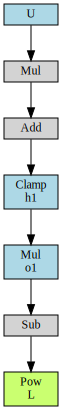

In [125]:
# RNN parameters
U_ = torch.Tensor([0.1]) # we use U_ instead of U (etc.) to avoid autograding issues
V_ = torch.Tensor([0.2])
W_ = torch.Tensor([0.3])

# inputs
x1_ = torch.Tensor([0.5])
x2_ = torch.Tensor([0.6])
x3_ = torch.Tensor([0.7])

# initial value for the hidden state, a zero vector
h0_ = torch.Tensor([0])

# Set which nodes to visualize later
visualized_nodes = [U_, ]
for p in visualized_nodes:
    p.requires_grad = True

# Calculate h1, o1
h1_ = torch.clamp(U_ * x1_ + V_ * h0_, min=0)
o1_ = W_ * h1_

L_ = (o1_ - x2_) ** 2

params = {k: eval(k+'_') for k in ['L', 'U', 'h1', 'o1']}
dot = make_dot(L_, params=params)
# Save Graph to `computation_graph_1.pdf`
dot.render('computation_graph_1')
dot

<!-- BEGIN QUESTION -->

---

**Question:** Find a formula for $\frac{\partial L(\vect{U}, \vect{V}, \vect{W}, x_1, x_2, h_0)}{\partial \vect{U}}$ in terms of $\frac{\partial L(o_1, x_2)}{\partial o_1}$, $\frac{\partial o_1(\vect{W}, h_1)}{\partial h_1}$ ,and $\frac{\partial h_1(\vect{U}, \vect{V}, h_0, x_1)}{\partial \vect{U}}$. You might find the above computation graph useful: how does $L$ depend on $\vect{U}$? 

>Note that in your answer you can omit the arguments of the functions for brevity (e.g., you can use $\frac{\partial L}{\partial o_1}$ instead of $\frac{\partial L(o_1, x_2)}{\partial o_1}$), but keep in mind that the arguments are important: e.g., $o_1$ eventually depends on $\vect{U}$, so $\frac{\partial o_1(\vect{U}, \vect{V}, \vect{W}, x_1, x_2, h_0)}{\partial \vect{U}}$ is likely not zero, but if instead we assume its arguments are $h_1$ and $\vect{W}$, i.e., $o_1 = o_1(h_1, \vect{W})$, then $\frac{\partial o_1}{\partial U}$ is undefined or 0, as when we take partial derivatives, we hold other arguments ($h_1$ and $\vect{W}$ in this case) as constant.

>Hint: Use the chain rule.

<!--
BEGIN QUESTION
name: open_response_backprop1
manual: true
-->

Clariffication about f(Ux_0): it is a matrix of 0 and 1 of size of U, where there is 1 anywhere where u_i,j*x_0 is bigger or equal to zero (if u_i,j*x_0 >= 0 then in f(Ux_0)_i,j there wiil be 1. Otherwise 0).
The derivatives is ofcourse taken using the chain rule:

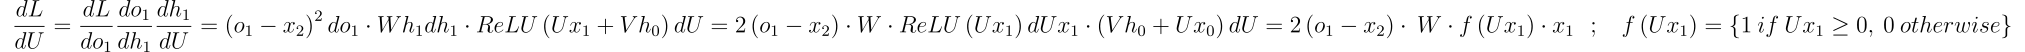

<!-- END QUESTION -->

Implement the backward step that you found for $\frac{\partial L}{\partial \vect{U}}$. Then, you will be able to verify your solution compared to the gradients achieved by PyTorch.

<!--
BEGIN QUESTION
name: backward
-->

In [126]:
# TODO: Implement dL/dU
def dL_dU(x1, x2, o1, h0, U, V, W):
    relu_d = (U*x1+V*h0 > 0).type(torch.FloatTensor)
    return 2*(o1-x2)*W*relu_d*x1


In [127]:
grader.check("backward")

All tests passed!

---

### RNN backprop on very short sequences

Consider an RNN run on an input sequence of length 2. This RNN's output sequence $o$ will consist of $o_1$ and $o_2$ and the loss will be

$$ L = (x_2 - o_1)^2 + (x_3 - o_2)^2 $$

Let's visualize the computation graph.

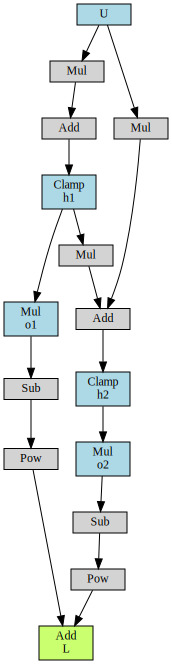

In [128]:
# RNN parameters
U_ = torch.Tensor([0.1])
V_ = torch.Tensor([0.2])
W_ = torch.Tensor([0.3])

# inputs
x1_ = torch.Tensor([0.5])
x2_ = torch.Tensor([0.6])
x3_ = torch.Tensor([0.7])

# initial value for the hidden state, a zero vector
h0_ = torch.Tensor([0])

# Set which nodes to visualize later
visualized_nodes = [U_, ]
for p in visualized_nodes:
    p.requires_grad = True

# Calculate h1, o1
h1_ = torch.clamp(U_ * x1_ + V_ * h0_, min=0)
h2_ = torch.clamp(U_ * x2_ + V_ * h1_, min=0)
o2_ = W_ * h2_
o1_ = W_ * h1_

L_ = (o1_ - x2_)**2 + (o2_ - x3_)**2

params = {k: eval(k+'_') for k in ['L', 'U', 'h1', 'o1', 'h2', 'o2']}

dot = make_dot(L_, params=params)
# Save Graph to `computation_graph_2.pdf`
dot.render('computation_graph_2')
dot

<!-- BEGIN QUESTION -->

---

**Question:** This time, find the formula for $\frac{\partial L(\vect{U}, \vect{V}, \vect{W}, x_1, x_2, x_3, h_0)}{\partial \vect{U}}$, the derivative of the loss $L$ with respect to the parameter $\vect{U}$ in terms of $\frac{\partial L(o_1, o_2, x_2, x_3)}{\partial o_t}$, $\frac{\partial o_t( \vect{W}, h_t)}{\partial h_t}$, $\frac{\partial h_2(\vect{U}, \vect{V}, h_1, x_2)}{\partial h_1}$, and $\frac{\partial h_t(\vect{U}, \vect{V}, h_{t-1}, x_t)}{\partial \vect{U}}$ for $t \in \{1,2\}$. You might find the above computation graph useful.

> How many possible paths are there in the computation graph from $\vect{U}$ to $L$? Each path corresponds to a term in the final answer.

> Hint: when we take $\frac{\partial h_2(\vect{U}, \vect{V}, h_1, x_2)}{\partial \vect{U}}$, we are holding other arguments (other than $\vect{U}$) as constants, such as $h_1$. Therefore, $\frac{\partial h_2}{\partial \vect{U}}$ does not reflect the path through $h_1$ that $\vect{U}$ can also exert influence on $h_2$: $\vect{U} \to h_1 \to h_2$.

<!--
BEGIN QUESTION
name: open_response_backprop2
manual: true
-->

* a little notation fix: U should be dU in the derivatives section.

We can notice that the total loss can be expressed in the following way (in that way it is a little bit more simple to follow all the components of the derivatives and the pathes):

* Explanation: we can look at the different pathes according to the loss w.r.t the timestamp. So for one input there is only one time stamp and x_2 as the label. With two inputs we can look at the loss w.r.t the first timestamp and then the second, where the first contains only one path, the second is influenced by the current h and the previous, and so on, so the losses are accumulated, and the pathes are also can be "devided" appropriately to the loss at each timpestamp.
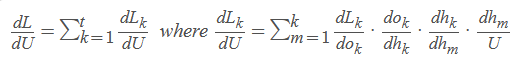

this way, let's calculate all the L_i's:
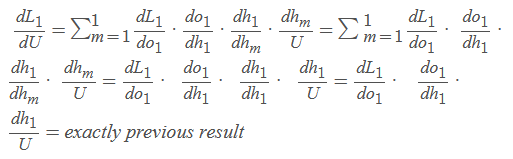

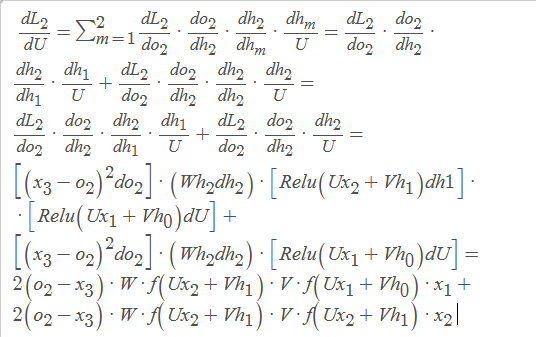


And the whole gradient will be the sum of both (the path which is expressed by the previous term and the 2 pathes represented by two derivative terms, which summarized, in the loss which belongs to the second timestamp).

* f is the element-wise function which gives the value 1 if the corresponding element (in our cases the element of the sum of the multiplications of the vectors/matrices) bigger then 0, 0 otherwise. This notation also used next and previously was explained also.



<!-- END QUESTION -->



---
## Bonus section: 

> **This section is more challenging in nature and is therefore a bonus.**



<!-- BEGIN QUESTION -->


Above, you worked out the solution for implementing a bigram model for a two-word vocabulary as an RNN. But the construction can be generalized for bigram models over vocabularies of arbitrary size, say, $N$ word types.

<!--
BEGIN QUESTION
name: open_response_bigram
manual: true
-->

---

**Question:** 
In general, given a transition matrix $T_{N\times N}$, what would be the activation function $\sigma$ and the parameters $\vect{U}$, $\vect{V}$, and $\vect{W}$,  of an RNN that outputs $T_i$ given $v_i$ as an input?

_Type your answer here, replacing this text._

<!-- END QUESTION -->



### RNN backprop on short sequences

For the penultimate backprop challenge, consider an RNN run on an input sequence of length 3. This RNN's output sequence $o$ will consist of $o_1$, $o_2$, and $o_3$.

Let's look at the computation graph. How many possible paths are there from $\vect{U}$ to $L$? How many $h$ elements are there in each path?

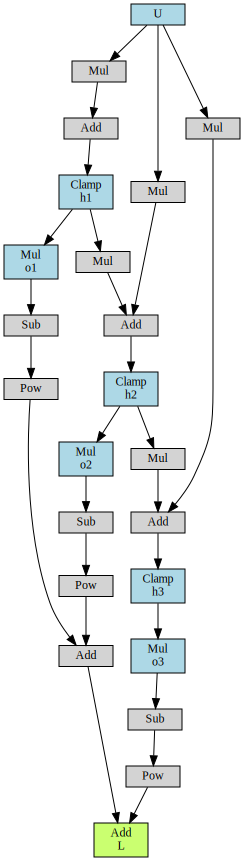

In [129]:
# RNN parameters
U_ = torch.Tensor([0.1])
V_ = torch.Tensor([0.2])
W_ = torch.Tensor([0.3])

# inputs
x1_ = torch.Tensor([0.5])
x2_ = torch.Tensor([0.6])
x3_ = torch.Tensor([0.7])
x4_ = torch.Tensor([0.8])

# initial value for the hidden state, a zero vector
h0_ = torch.Tensor([0])

# Set which nodes to visualize later
visualized_nodes = [U_, ]
for p in visualized_nodes:
    p.requires_grad = True

# Calculate h1, o1
h1_ = torch.clamp(U_ * x1_ + V_ * h0_, min=0)
h2_ = torch.clamp(U_ * x2_ + V_ * h1_, min=0)
h3_ = torch.clamp(U_ * x3_ + V_ * h2_, min=0)
o3_ = W_ * h3_
o2_ = W_ * h2_
o1_ = W_ * h1_

L_ = (o1_ - x2_)**2 + (o2_ - x3_)**2 + (o3_ - x4_)**2

params = {k: eval(k+'_') for k in ['L', 'U', 'h1', 'o1', 'h2', 'o2', 'h3', 'o3']}

dot = make_dot(L_, params=params)
# Save Graph to `computation_graph_3.pdf`
dot.render('computation_graph_3')
dot

<!-- BEGIN QUESTION -->

---

**Question:** This time, find the formula for $\frac{\partial L(\vect{U}, \vect{V}, \vect{W}, x_1, x_2, x_3, x_4, h_0)}{\partial \vect{U}}$ in terms of $\frac{\partial L(o_1,o_2,o_3,x_2,x_3,x_{4})}{\partial o_t}$, $\frac{\partial o_t(\vect{W}, h_t)}{\partial h_t}$, $\frac{\partial h_t(\vect{U}, \vect{V}, h_{t-1}, x_t)}{\partial h_{t-1}}$, and $\frac{\partial h_t(\vect{U}, \vect{V}, h_{t-1}, x_t)}{\partial \vect{U}}$ for $t \in \{1, 2, 3\}$.

> You should start to see a pattern emerging from this solution.

<!--
BEGIN QUESTION
name: open_response_backprop3
manual: true
-->

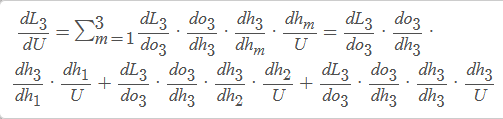

and the whole answer will be the sum of this loss with the two previous calculated in the previous section (before the bonus)

for the fullness an important it holds that:
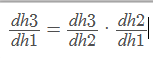




<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

---

### Looking back

In the last few problems your answers were in terms of partial derivatives that we gave you. In this exercise you will calculate part of a partial derivative.

---

**Question:** Referring back to the first problem in this lab, recall that 

$$ \vect{U} = \begin{bmatrix} -0.3 & 0.6 \\ 0.2 & 0.1 \end{bmatrix}, \vect{V} = \begin{bmatrix} 0.4 & 0.4 \\ 0.9 & -0.7 \end{bmatrix}, x_1 = \begin{bmatrix} 0 \\ 1 \end{bmatrix},   h_0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$$
               
Find the partial derivative $\frac{\partial h_{1}}{\partial U_{1,1}}$, where $U_{1,1}$ is the first row and first column of the matrix $\vect{U}$.

> **Hint:** We didn't tell you what the function $\sigma$ is. Turns out you will not need it! If you set it up right, you will see that you will not have to do much math at all.

<!--
BEGIN QUESTION
name: open_response_looking_back
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

---

Now, let's verify your solution above using PyTorch, which can calculate gradients automatically. Below shows an example on how to calculate gradients. Adapt it to find the gradients of $\frac{\partial h_{1,1}}{\partial \vect{U}}$ (where $h_{1,1}$ denotes the first element of vector $h_1$, and here we are taking the derivative with respect to the entire matrix $\vect{U}$). Use ReLU as $\sigma$.


<!--
BEGIN QUESTION
name: automatic_diff
-->

In [130]:
# TODO: modify the code below to find the gradients of 
# $\frac{\partial h_{1,1}}{\partial \vect{U}}$

# RNN parameters
U_ = torch.Tensor([ [-0.3,  0.6],
               [ 0.2,  0.1] ])
V_ = torch.Tensor([ [ 0.4,  0.4],
               [ 0.9, -0.7] ])
U_.requires_grad = True

# inputs
x1_ = torch.Tensor([0.0, 1.0])

# initial value for the hidden state, a zero vector
h0_ = torch.Tensor([0, 0])
h1_ = ...
h11 = ...

# The magic gradient computation
h11.backward()
U_grad = U_.grad
print (f'Gradient of W: {U_grad}')

AttributeError: ignored

In [ ]:
grader.check("automatic_diff")

Does the computed gradient agree with your calculation of $\frac{\partial h_{1}}{\partial U_{1,1}}$ (Note that here you only calculated $\frac{\partial h_{1,1}}{\partial \vect{U}}$ through PyTorch, so let's just focus on $\frac{\partial h_{1,1}}{\partial U_{1,1}}$)?

By now, hopefully you have got some idea on how PyTorch computes gradients with respect to $\vect{U}$ by calling a `backward` function on `h11`: the reason is that PyTorch maintains an underlying computation graph, and it can find all ancestors of `h11` (including $\vect{U}$). The gradient computation process is essentially applying chain rules on this computation graph. (Think of how you would implement it yourself.)

<!-- BEGIN QUESTION -->

RNN backprop on arbitrary sequences
The final challenge! Consider an RNN run on an input sequence of length $N$. 

---

**Question:** Find a general formula for $\frac{\partial L(\vect{U}, \vect{V}, \vect{W}, x_1,\cdots, x_{N+1}, h_0)}{\partial \vect{U}}$ in terms of $\frac{\partial L(o_1,\cdots,o_N, x_2, \cdots, x_{N+1})}{\partial o_t}$, $\frac{\partial o_t(\vect{W}, h_t)}{\partial h_t}$, $\frac{\partial h_t(\vect{U}, \vect{V}, h_{t-1}, x_t)}{\partial h_{t-1}}$, and $\frac{\partial h_t(\vect{U}, \vect{V}, h_{t-1}, x_t)}{\partial \vect{U}}$ for $t \in \{1, \ldots, N\}$.

> How many terms are there when $N$ is 1, 2, or 3? How many possible paths are there from $\vect{U}$ to $L$ in the computation graph?

> Your solution might look a little like
$$ \sum + \sum\left(\sum\left(\prod\right)\right) $$

<!--
BEGIN QUESTION
name: open_response_backprop4
manual: true
-->

As we allready noticed in the section previous to the bonus, we can conclude that the whole formula in total is: 

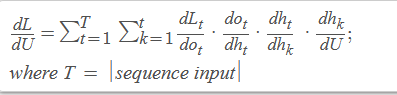


and as with the example above the h term need additional development:
for my personal opinion it is more little bit more elegant because it doesn't need the division to sole sigma and the rest.


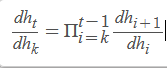



This formula is totally equal to the formula of the written form (just a little reindexing). 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

---

## Lab debrief – for consensus submission only

**Question:** We're interested in any thoughts your group has about this lab so that we can improve this lab for later years, and to inform later labs for this year. Please list any issues that arose or comments you have to improve the lab. Useful things to comment on include the following: 

* Was the lab too long or too short?
* Were the readings appropriate for the lab? 
* Was it clear (at least after you completed the lab) what the points of the exercises were? 
* Are there additions or changes you think would make the lab better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



# End of lab 2-2

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [131]:
grader.check_all()

automatic_diff:

    
    0 of 1 tests passed
    
    
    Tests failed:
    
           tests/automatic_diff.py

Test result:
Trying:
    U_grad.shape
Expecting:
    torch.Size([2, 2])
**********************************************************************
Line 1, in tests/automatic_diff.py 0
Failed example:
    U_grad.shape
Exception raised:
    Traceback (most recent call last):
      File "/usr/lib/python3.6/doctest.py", line 1330, in __run
        compileflags, 1), test.globs)
      File "<doctest tests/automatic_diff.py 0[0]>", line 1, in <module>
        U_grad.shape
    NameError: name 'U_grad' is not defined

    
    
    
    

backward:

    All tests passed!
    

bigram:

    All tests passed!
    

forward:

    All tests passed!
    

tiny_bigram_RNN:

    All tests passed!